In [ ]:
# # EXPERIMENTING WIT LAGGING THIS IS FOR FEATURE ENGINEERING 
# # Create a lagged version of the El Niño dataset, shifting by 3 months (90 days)
# df_nino_lagged = nino_indices_df.with_columns((pl.col('time') + pl.duration(days=90)).alias('time_lagged'))

In [ ]:
# df_nino_lagged = df_nino_lagged.with_columns(
#     pl.col('time_lagged').dt.date().alias('time_lagged')
# )

In [ ]:
# output_file_path = '/workspace/soil-ml-modeling-pipeline/ml-modeling-pipeline/data/02_intermediate/preprocessed_nino_data.parquet'
# df_nino_lagged.write_parquet(output_file_path)

In [ ]:
# # Load meteorlogical data from NASA
# df_nino_lagged = pl.read_parquet("/workspace/soil-ml-modeling-pipeline/ml-modeling-pipeline/data/02_intermediate/preprocessed_nino_data.parquet")

In [1]:
import pandas as pd

df = pd.read_parquet("ml-drought-forecasting/ml-modeling-pipeline/data/03_primary/preprocessed_data.parquet")

In [2]:
df 

,lat,lon,time,T2M,T2M_MAX,T2M_MIN,TS,PS,WS2M,WS10M,...,eddi_12mn,Nino12,Nino3,Nino34,Nino4,WTIO,SETIO,DMI,SWIO,PRECTOTCORR_mm
0,-11.5,35.000,1981-09-06,22.741741,27.502902,17.166964,297.361607,92626.794643,3.510045,4.493304,...,-0.939995,-0.477185,-0.228789,-0.218690,-0.044586,-0.509883,-0.169278,-0.340605,-0.89585,0.007279
1,-11.5,35.625,1981-09-06,24.041964,31.022991,16.844420,299.187500,94041.008929,2.733259,3.920759,...,-1.019687,-0.477185,-0.228789,-0.218690,-0.044586,-0.509883,-0.169278,-0.340605,-0.89585,0.016303
2,-11.5,36.250,1981-09-06,24.779688,31.501786,17.574330,300.176339,94787.687500,3.065848,4.257812,...,-0.805642,-0.477185,-0.228789,-0.218690,-0.044586,-0.509883,-0.169278,-0.340605,-0.89585,0.015900
3,-11.5,36.875,1981-09-06,25.352232,31.976116,18.473884,300.858259,95724.160714,3.169643,4.335938,...,-0.614502,-0.477185,-0.228789,-0.218690,-0.044586,-0.509883,-0.169278,-0.340605,-0.89585,0.076717
4,-11.5,37.500,1981-09-06,25.962723,32.656920,19.208259,301.693080,96682.500000,3.138393,4.276786,...,-0.614502,-0.477185,-0.228789,-0.218690,-0.044586,-0.509883,-0.169278,-0.340605,-0.89585,0.124541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3648995,22.0,33.125,2024-04-21,31.287500,40.280804,21.885714,306.502232,97233.776786,3.052455,4.222098,...,1.781517,0.726098,0.852931,0.955012,1.024732,1.081862,0.645607,0.436255,0.29154,0.000000
3648996,22.0,34.375,2024-04-21,31.587723,40.312054,22.601116,307.595982,96014.964286,3.462054,4.595982,...,1.555058,0.726098,0.852931,0.955012,1.024732,1.081862,0.645607,0.436255,0.29154,0.000915
3648997,22.0,35.000,2024-04-21,29.749554,38.291964,21.685938,306.118304,93760.491071,3.770089,4.936384,...,1.555058,0.726098,0.852931,0.955012,1.024732,1.081862,0.645607,0.436255,0.29154,0.500129
3648998,22.0,35.625,2024-04-21,28.631250,37.554241,20.646875,305.431920,93454.946429,3.435268,4.411830,...,1.555058,0.726098,0.852931,0.955012,1.024732,1.081862,0.645607,0.436255,0.29154,1.531598


In [3]:
df.columns

Index(['lat', 'lon', 'time', 'T2M', 'T2M_MAX', 'T2M_MIN', 'TS', 'PS', 'WS2M',
       'WS10M', 'WS50M', 'QV2M', 'QV10M', 'RH2M', 'TQV', 'T2MDEW', 'T2MWET',
       'DISPH', 'RHOA', 'TO3', 'TROPPB', 'TROPQ', 'TROPT', 'U10M', 'U2M',
       'U50M', 'V10M', 'V2M', 'V50M', 'WD10M', 'WD2M', 'WD50M', 'eddi_01mn',
       'eddi_02mn', 'eddi_03mn', 'eddi_06mn', 'eddi_09mn', 'eddi_12mn',
       'Nino12', 'Nino3', 'Nino34', 'Nino4', 'WTIO', 'SETIO', 'DMI', 'SWIO',
       'PRECTOTCORR_mm'],
      dtype='object')

In [4]:
# ENSO Index
df['ENSO_Index'] = df[['Nino3', 'Nino34', 'Nino4']].mean(axis=1)

# IOD Index
df['IOD_Index'] = df['WTIO'] - df['SETIO']

# Step 1: Ensure 'time' is datetime and modify it to represent each month
df['time'] = pd.to_datetime(df['time']).dt.to_period('M').dt.to_timestamp()

# Step 2: Define group columns and aggregation functions
group_cols = ['lat', 'lon', 'time']
data_cols = [col for col in df.columns if col not in group_cols]

# Initialize the aggregation_functions dictionary
aggregation_functions = {}
for col in data_cols:
    if col == 'PRECTOTCORR':
        aggregation_functions[col] = 'sum'  # Sum for precipitation
    elif col == 'T2M_MAX':
        aggregation_functions[col] = 'max'  # Max for maximum temperature
    elif col == 'T2M_MIN':
        aggregation_functions[col] = 'min'  # Min for minimum temperature
    else:
        aggregation_functions[col] = 'mean'  # Mean for all other columns

# Step 3: Perform the aggregation and assign back to df
df = df.groupby(group_cols).agg(aggregation_functions).reset_index()

# Ensure 'time' is datetime and modify it to represent each month
df['time'] = pd.to_datetime(df['time']).dt.to_period('M').dt.to_timestamp()

# Sort the DataFrame by 'lat', 'lon', 'time'
df = df.sort_values(['lat', 'lon', 'time'])

# Define the columns to lag and the lag periods
lag_columns = [
    'Nino12', 'Nino3', 'Nino34', 'Nino4', 'WTIO', 'SETIO', 'DMI', 'SWIO',
]

lags = [1, 2, 3, 6, 9, 12]

# Create lagged columns
for lag in lags:
    for col in lag_columns:
        new_col_name = f"{col}_lag{lag}m"
        df[new_col_name] = df.groupby(['lat', 'lon'])[col].shift(lag)

df = df.dropna()

In [5]:
df

,lat,lon,time,T2M,T2M_MAX,T2M_MIN,TS,PS,WS2M,WS10M,...,DMI_lag9m,SWIO_lag9m,Nino12_lag12m,Nino3_lag12m,Nino34_lag12m,Nino4_lag12m,WTIO_lag12m,SETIO_lag12m,DMI_lag12m,SWIO_lag12m
12,-11.5,35.00,1982-09-01,23.201842,29.287500,16.601116,297.725167,92689.486607,4.571150,5.812500,...,-0.290936,-0.372644,-0.595026,-0.330471,-0.329727,-0.217738,-0.518478,-0.121473,-0.397005,-0.715519
13,-11.5,35.00,1982-10-01,26.042634,32.255134,20.204911,300.528125,92307.439286,4.676786,5.935045,...,0.004117,-0.279702,-0.724929,-0.103242,-0.119088,0.012834,-0.185734,0.084897,-0.270631,-0.967159
14,-11.5,35.00,1982-11-01,26.147154,33.480580,21.376786,300.479353,92229.437500,3.861049,4.862165,...,0.534219,-0.433509,-0.424857,-0.394508,-0.395296,-0.046184,-0.533322,-0.339751,-0.193571,-0.445301
15,-11.5,35.00,1982-12-01,24.946819,29.718304,21.527455,299.032645,92214.685268,2.868304,3.616350,...,0.444011,-0.561140,-0.056296,-0.127676,-0.322644,-0.183712,-0.600448,-0.309513,-0.290936,-0.372644
16,-11.5,35.00,1983-01-01,24.699107,28.675893,21.351116,298.791964,92313.048214,2.614509,3.289509,...,0.607070,-0.356106,-0.211071,0.095280,0.008554,-0.207484,-0.533448,-0.537565,0.004117,-0.279702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839675,22.0,36.25,2023-12-01,22.768973,31.803125,15.389063,298.092634,97213.323214,2.670759,3.486607,...,0.369117,0.495723,-0.314661,-0.735020,-0.754585,-0.595349,0.161751,-0.227783,0.389535,0.684834
839676,22.0,36.25,2024-01-01,19.756808,29.391295,10.985045,295.298270,97399.087054,2.886998,3.744420,...,0.288493,0.299338,-0.180578,-0.546297,-0.727329,-0.553051,-0.059435,-0.213934,0.154499,0.495811
839677,22.0,36.25,2024-02-01,20.507087,30.055357,13.402455,296.125558,97233.341518,3.003069,3.898438,...,0.124564,0.316673,1.195070,-0.062938,-0.494416,-0.516595,-0.110629,-0.642643,0.532014,0.678333
839678,22.0,36.25,2024-03-01,24.272545,35.279688,15.093304,300.484598,96960.975000,2.895536,3.685938,...,-0.024731,0.124910,1.883659,0.500063,0.054890,0.010721,0.227372,-0.141746,0.369117,0.495723


In [9]:
# Save the DataFrame
df.to_parquet("ml-drought-forecasting/ml-modeling-pipeline/data/04_feature/features.parquet")

[0]	train-rmse:0.87058	eval-rmse:0.90031
[50]	train-rmse:0.39333	eval-rmse:0.52735
[100]	train-rmse:0.35471	eval-rmse:0.51953
[124]	train-rmse:0.34104	eval-rmse:0.52113
MSE: 0.27157700061798096, R^2: 0.7058327487915035
        Feature   Importance
32    eddi_06mn  5036.604980
33    eddi_09mn   452.286407
53  Nino3_lag2m   262.901154
61  Nino3_lag3m   206.242981
38         WTIO   181.121048
47  Nino4_lag1m   172.471603
29    eddi_01mn   159.121429
36       Nino34   152.280075
45  Nino3_lag1m   143.089157
55  Nino4_lag2m   138.510666


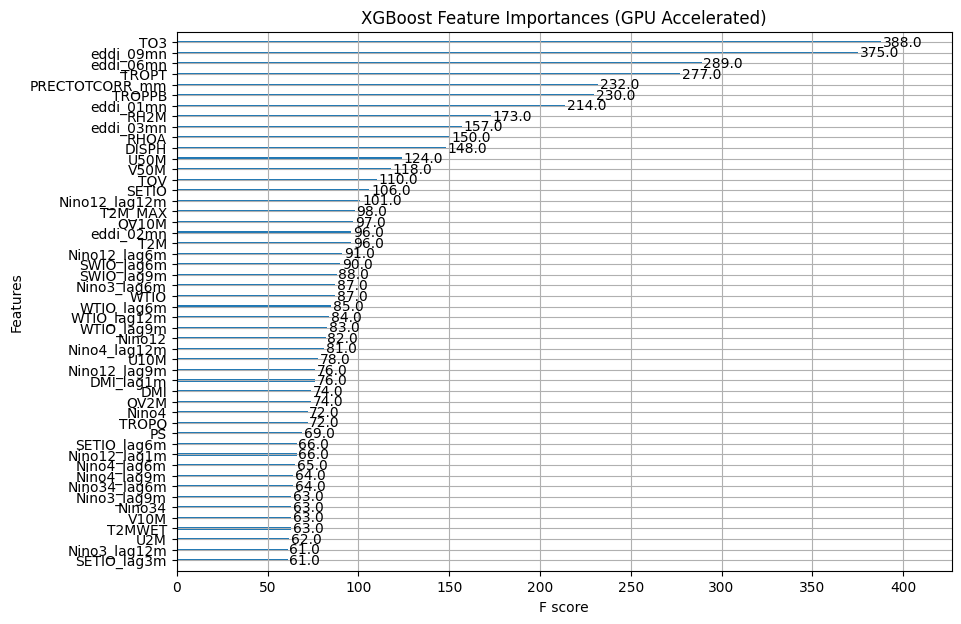

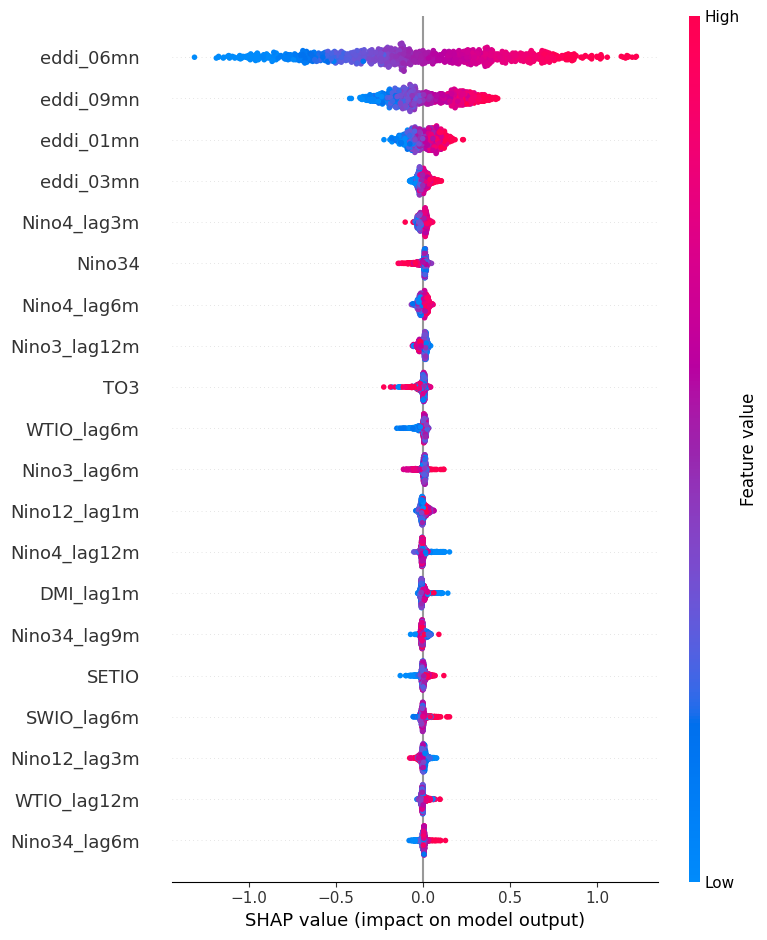

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Shift the target variable back by 6 steps
df['eddi_12mn_t_plus_6'] = df['eddi_12mn'].shift(-6)

# Drop rows with NaN in the target variable (last 6 rows)
df = df.dropna(subset=['eddi_12mn_t_plus_6']).reset_index(drop=True)

# Prepare the data
feature_columns = df.columns.drop(['eddi_12mn', 'eddi_12mn_t_plus_6', 'time', 'lat', 'lon'])
X = df[feature_columns].copy()  # Explicitly create a copy
y = df['eddi_12mn_t_plus_6']

# Downcast data types
for col in X.select_dtypes(include=['float64', 'int64']).columns:
    X[col] = pd.to_numeric(X[col], downcast='float')

# Proceed with splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, shuffle=False  # Do not shuffle for time series
)

# Initialize and apply the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames with original column names
X_train_scaled = pd.DataFrame(
    X_train_scaled, columns=X_train.columns, index=X_train.index
)
X_test_scaled = pd.DataFrame(
    X_test_scaled, columns=X_test.columns, index=X_test.index
)

# Create DMatrix for XGBoost with scaled data and feature names
dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)

# Set up parameters for XGBoost with updated GPU settings
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'tree_method': 'hist',  # Use 'hist' instead of 'gpu_hist' if GPU not available
    'device': 'cuda',       # Specify GPU device
    'max_depth': 6,
    'eta': 0.1,
    'subsample': 0.8,
    'random_state': 42
}

# Train the model
evals = [(dtrain, 'train'), (dtest, 'eval')]
xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=20,
    evals=evals,
    verbose_eval=50
)

# Evaluate the model
y_pred = xgb_model.predict(dtest)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MSE: {mse}, R^2: {r2}')

# Extract feature importances
importance_dict = xgb_model.get_score(importance_type='gain')
importances = pd.DataFrame({
    'Feature': importance_dict.keys(),
    'Importance': importance_dict.values()
})
importances.sort_values(by='Importance', ascending=False, inplace=True)
print(importances.head(10))

# Plot feature importances
plt.rcParams['figure.figsize'] = [10, 7]
ax = xgb.plot_importance(xgb_model, max_num_features=50)
plt.title('XGBoost Feature Importances (GPU Accelerated)')
plt.show()

# Compute SHAP values
explainer = shap.TreeExplainer(xgb_model)
X_test_sample = X_test_scaled.sample(n=1000, random_state=42)
shap_values = explainer.shap_values(X_test_sample)

# SHAP summary plot
shap.summary_plot(shap_values, X_test_sample, feature_names=X.columns)
